# Tutorial 8: Workflow Example

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/donishadsmith/neurocaps/blob/stable/docs/examples/tutorial-8.ipynb)

This tutorial demonstrates an example workflow from timeseries extraction to CAPs visualization. Two subjects from a real, publicly available dataset are used so it may take a few minutes to download the files.

In [1]:
# Download packages
try:
    import neurocaps
except:
    !pip install neurocaps[windows,demo]

# Set headless display for google colab
import os, sys

if "google.colab" in sys.modules:
    os.environ["DISPLAY"] = ":0.0"
    !apt-get install -y xvfb
    !Xvfb :0 -screen 0 1024x768x24 &> /dev/null &
    !Xvfb :0 -screen 0 1024x768x24 &> /dev/null &

In [2]:
import os

demo_dir = "neurocaps_demo_workflow"
os.makedirs(demo_dir, exist_ok=True)

The code below fetches two subjects from an [OpenNeuro dataset](https://openneuro.org/datasets/ds003521/versions/2.2.0) ([from Chang et al. (2021)](https://doi.org/10.1126/sciadv.abf7129))
preprocessed with [fMRIPrep](https://fmriprep.org/en/stable/). Downloading data from OpenNeuro requires
``pip install openneuro-py ipywidgets`` or ``pip install neurocaps[demo]``.

In [ ]:
# [Dataset] https://openneuro.org/datasets/ds003521/versions/2.2.0
from openneuro import download

# Include data from two subjects
include = [
    "dataset_description.json",
    "derivatives/fmriprep/dataset_description.json",
    "sub-sid000216/func/*events.tsv",
    "derivatives/fmriprep/sub-sid000216/func/*confounds_timeseries.tsv",
    "derivatives/fmriprep/sub-sid000216/func/*preproc_bold.nii.gz",
    "sub-sid000710/func/*events.tsv",
    "derivatives/fmriprep/sub-sid000710/func/*confounds_timeseries.tsv",
    "derivatives/fmriprep/sub-sid000710/func/*preproc_bold.nii.gz",
]

download(
    dataset="ds003521",
    include=include,
    target_dir=demo_dir,
    verify_hash=False,
    max_retries=10,
    max_concurrent_downloads=8,
)


👋 Hello! This is openneuro-py 2024.2.0. Great to see you! 🤗

   👉 Please report problems 🤯 and bugs 🪲 at
      https://github.com/hoechenberger/openneuro-py/issues

🌍 Preparing to download ds003521 …


📁 Traversing directories for ds003521 : 0 entities [00:00, ? entities/s]

📥 Retrieving up to 11 files (8 concurrent downloads). 
✅ Finished downloading ds003521.
 
🧠 Please enjoy your brains.
 


Skipping sub-sid000710_task-movie_run-1_desc-confounds_timeseries.tsv: already downloaded.: 100%|##########| 1…

Skipping sub-sid000216_task-movie_run-1_desc-confounds_timeseries.tsv: already downloaded.: 100%|##########| 1…

Skipping dataset_description.json: already downloaded.: 100%|##########| 1.10k/1.10k [00:00<?, ?B/s]

Skipping sub-sid000216_task-movie_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz: already downloaded…

Skipping README: already downloaded.: 100%|##########| 8.06k/8.06k [00:00<?, ?B/s]

Skipping dataset_description.json: already downloaded.: 100%|##########| 696/696 [00:00<?, ?B/s]

Skipping CHANGES: already downloaded.: 100%|##########| 630/630 [00:00<?, ?B/s]

Skipping participants.tsv: already downloaded.: 100%|##########| 974/974 [00:00<?, ?B/s]

Skipping sub-sid000710_task-movie_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz: already downloaded…

Skipping sub-sid000216_task-movie_run-01_events.tsv: already downloaded.: 100%|##########| 71.0/71.0 [00:00<?,…

Skipping sub-sid000710_task-movie_run-01_events.tsv: already downloaded.: 100%|##########| 71.0/71.0 [00:00<?,…

The first level of the pipeline directory must also have a dataset_description.json file for querying purposes.


In [6]:
import glob, os

# Ensure all files have the same run id if the "run-" entity is used.
for sub in ["sub-sid000216", "sub-sid000710"]:
    target_file = glob.glob(os.path.join(demo_dir, sub, "func", "*events.tsv"))[0]
    os.rename(target_file, target_file.replace("run-01", "run-1"))

In [7]:
from neurocaps.extraction import TimeseriesExtractor
from neurocaps.utils import fetch_preset_parcel_approach

# List of fMRIPrep-derived confounds for nuisance regression
confound_names = [
    "cosine*",
    "trans_x",
    "trans_x_derivative1",
    "trans_y",
    "trans_y_derivative1",
    "trans_z",
    "trans_z_derivative1",
    "rot_x",
    "rot_x_derivative1",
    "rot_y",
    "rot_y_derivative1",
    "rot_z",
    "rot_z_derivative1",
    "a_comp_cor_00",
    "a_comp_cor_01",
    "a_comp_cor_02",
    "a_comp_cor_03",
    "a_comp_cor_04",
    "global_signal",
    "global_signal_derivative1",
]

# Initialize extractor with signal cleaning parameters
extractor = TimeseriesExtractor(
    space="MNI152NLin2009cAsym",
    parcel_approach=fetch_preset_parcel_approach("4S", n_nodes=456),
    standardize=True,
    confound_names=confound_names,
    fd_threshold={
        "threshold": 0.50,
        "outlier_percentage": 0.30,
    },
)

# Perform the timeseries extraction; only one session
# can be extracted at a time. Internally, lru_cache is used for
# ``BidsLayout``. May need to clear cache if the cell was ran
# before the directory download completed
try:
    TimeseriesExtractor._call_layout.cache_clear()
except:
    pass

# Extract BOLD data from preprocessed fMRIPrep data
# which should be located in the "derivatives" folder
# within the BIDS root directory
# The extracted timeseries data is automatically stored
# Session 2 is the only session available, so `session`
# does not need to be specified
extractor.get_bold(
    bids_dir=demo_dir,
    task="movie",
    condition="Movie",
    condition_tr_shift=2,
    tr=2,
    n_cores=1,
    verbose=False,
).timeseries_to_pickle(demo_dir, "timeseries.pkl")

2025-07-29 12:18:16,760 neurocaps.extraction._internals.confounds [INFO] Confound regressors to be used if available: cosine*, trans_x, trans_x_derivative1, trans_y, trans_y_derivative1, trans_z, trans_z_derivative1, rot_x, rot_x_derivative1, rot_y, rot_y_derivative1, rot_z, rot_z_derivative1, a_comp_cor_00, a_comp_cor_01, a_comp_cor_02, a_comp_cor_03, a_comp_cor_04, global_signal, global_signal_derivative1.
2025-07-29 12:18:19,825 neurocaps.extraction.timeseries_extractor [INFO] BIDS Layout: ...orials\neurocaps_demo_workflow | Subjects: 2 | Sessions: 0 | Runs: 2


In [8]:
# Retrieve the dataframe containing QC information for each subject
# to use for downstream statistical analyses
qc_df = extractor.report_qc()
qc_df

,Subject_ID,Run,Mean_FD,Std_FD,Frames_Scrubbed,Frames_Interpolated,Mean_High_Motion_Length,Std_High_Motion_Length,N_Dummy_Scans
0,sid000216,run-1,0.082952,0.057038,2,0,1.00,0.000000,NaN
1,sid000710,run-1,0.083742,0.069571,5,0,1.25,0.433013,NaN


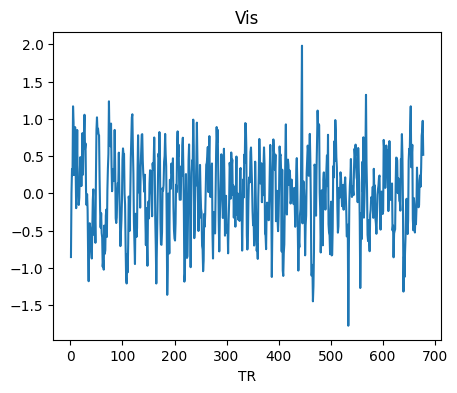

In [9]:
# Visualize BOLD Data
from neurocaps.utils import PlotDefaults

plot_kwargs = PlotDefaults.visualize_bold()
plot_kwargs["figsize"] = (5, 4)

extractor.visualize_bold(subj_id="sid000216", run=1, region="Vis", **plot_kwargs)

2025-07-29 12:18:48,015 neurocaps.analysis.cap._internals.cluster [INFO] No groups specified. Using default group 'All Subjects' containing all subject IDs from `subject_timeseries`. The `groups` dictionary will remain fixed unless the `CAP` class is re-initialized or `clear_groups()` is used.
2025-07-29 12:18:52,009 neurocaps.analysis.cap._internals.cluster [INFO] [GROUP: All Subjects | METHOD: variance_ratio] Optimal cluster size is 2.


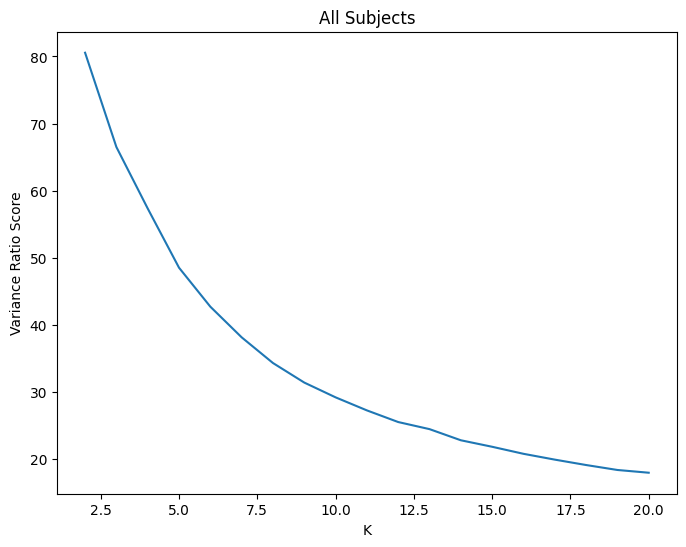

In [10]:
from neurocaps.analysis import CAP

# Initialize CAP class
cap_analysis = CAP(parcel_approach=extractor.parcel_approach)

# Identify the optimal number of CAPs (clusters)
# using the variance_ratio method to test 2-20
# The optimal number of CAPs is automatically stored
cap_analysis.get_caps(
    subject_timeseries=extractor.subject_timeseries,
    n_clusters=range(2, 21),
    standardize=True,
    cluster_selection_method="variance_ratio",
    max_iter=500,
    n_init=10,
    random_state=0,
    show_figs=True,
)

*Note*: For all subjects, CAP-2 has the highest frequency of appearance in the timeseries, 
suggesting that it is the dominant brain state most subjects occupy. However, a downstream
statistical analysis should be conducted to determine the significance of this finding.

In [ ]:
# Calculate temporal fraction of each CAP for all subjects
output = cap_analysis.calculate_metrics(
    extractor.subject_timeseries, metrics=["temporal_fraction", "transition_probability"]
)
output["temporal_fraction"]

,Subject_ID,Group,Run,CAP-1,CAP-2
0,sid000216,All Subjects,run-1,0.448378,0.551622
1,sid000710,All Subjects,run-1,0.422222,0.577778


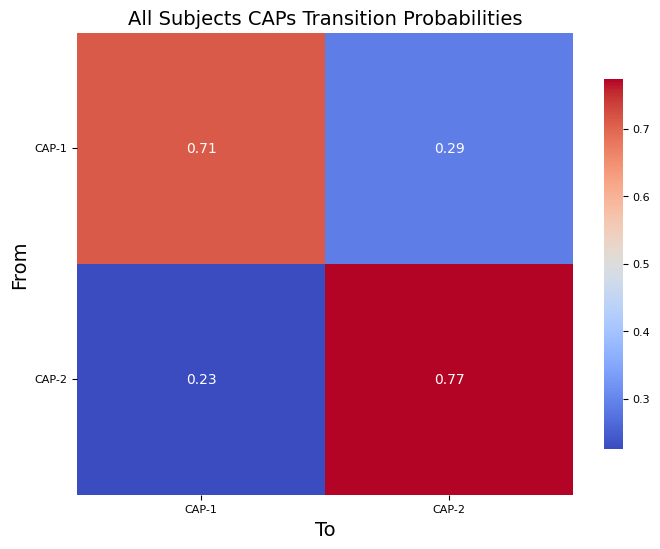

In [12]:
# Averaged transition probability matrix
from neurocaps.analysis import transition_matrix

df = transition_matrix(output["transition_probability"], return_df=True)

*Note*: Here CAP-1 is more likely to transition to itself than to CAP-2, likewise for CAP-2.


In [13]:
df["All Subjects"]

,CAP-1,CAP-2
From/To,,
CAP-1,0.710204,0.289796
CAP-2,0.226107,0.773893


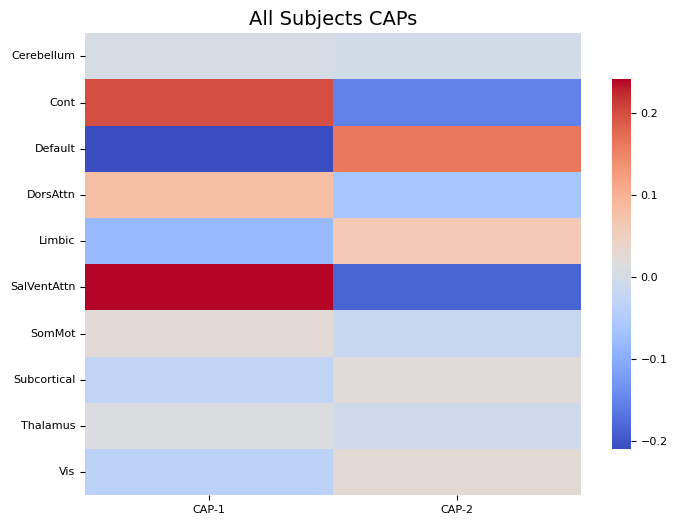

In [14]:
cap_analysis.caps2plot(plot_options="heatmap")

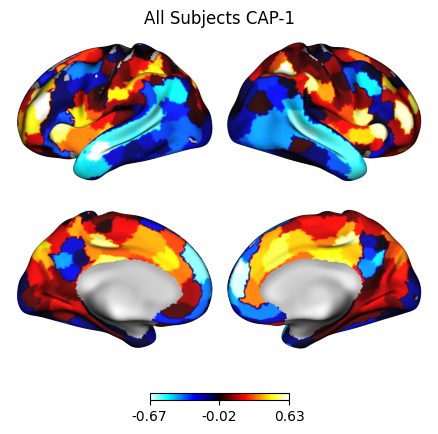

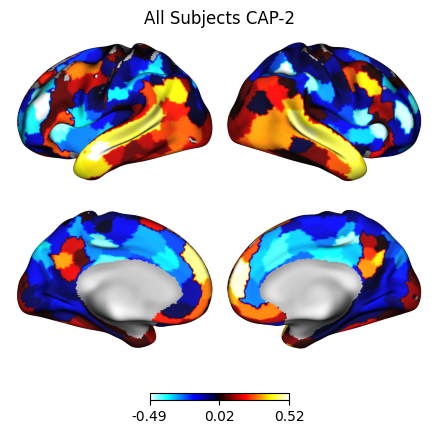

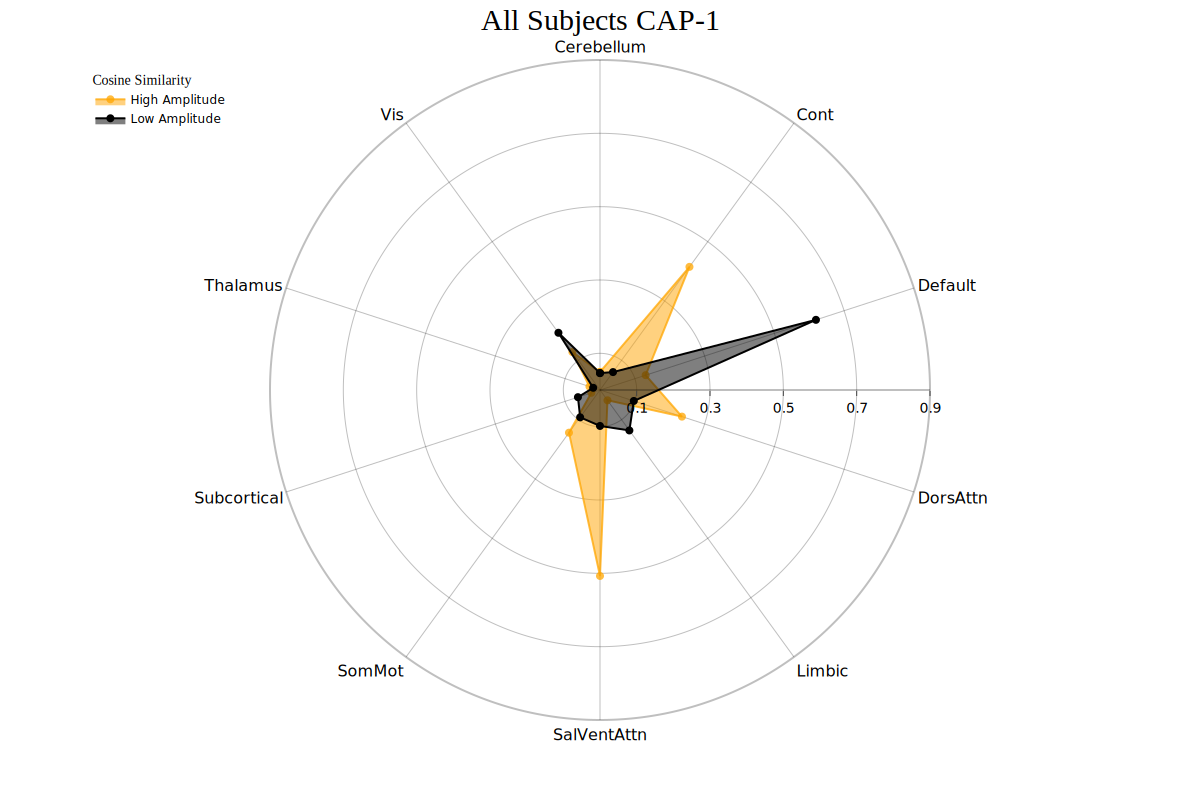

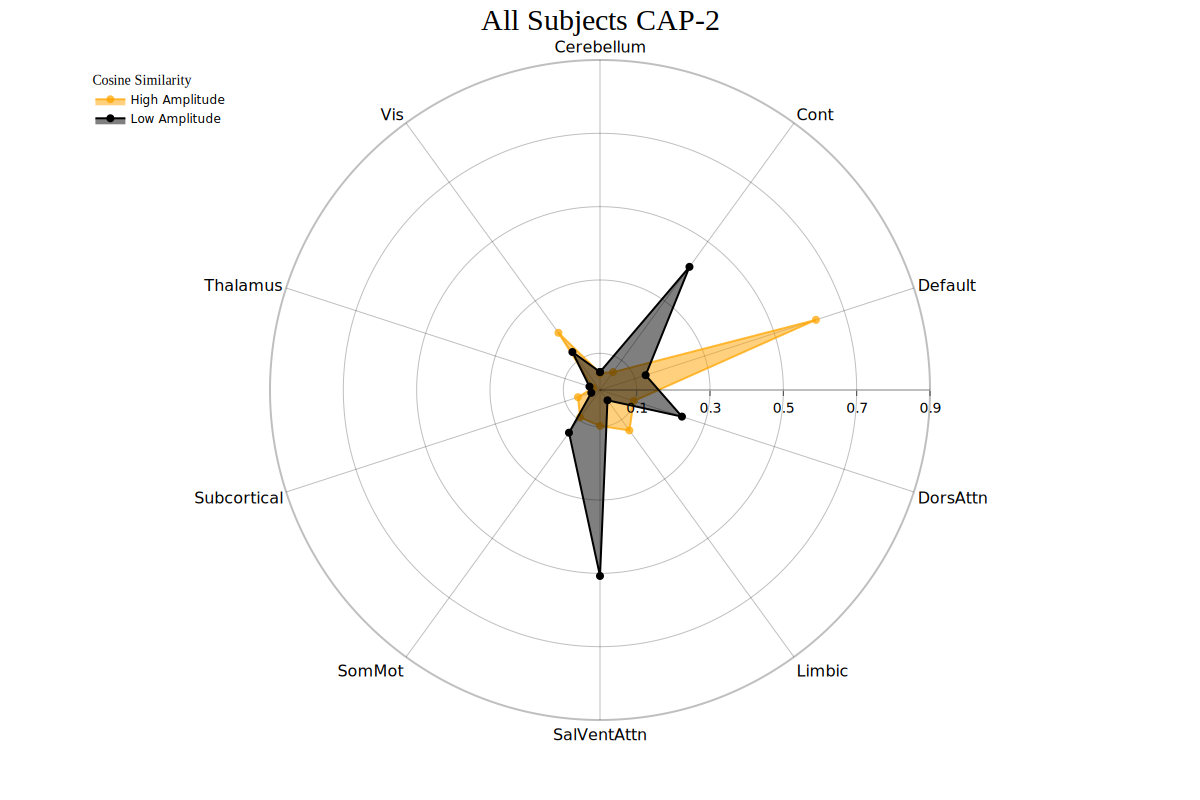

In [15]:
# Allow plotly to render correctly on static websites
import plotly.io as pio

pio.renderers.default = "svg"

# Project CAPs onto surface plots
# and generate cosine similarity network alignment of CAPs

from neurocaps.utils import PlotDefaults

radialaxis = {
    "showline": True,
    "linewidth": 2,
    "linecolor": "rgba(0, 0, 0, 0.25)",
    "gridcolor": "rgba(0, 0, 0, 0.25)",
    "ticks": "outside",
    "tickfont": {"size": 14, "color": "black"},
    "range": [0, 0.9],
    "tickvals": [0.1, "", 0.3, "", 0.5, "", 0.7, "", 0.9],
}

color_discrete_map = {
    "High Amplitude": "rgba(255, 165, 0, 0.75)",
    "Low Amplitude": "black",
}

plot_kwargs = PlotDefaults.caps2radar()
plot_kwargs.update(dict(radialaxis=radialaxis, color_discrete_map=color_discrete_map))

cap_analysis.caps2surf().caps2radar(**plot_kwargs)

For the radar images, the "High Amplitude" represents network alignment to the positive
activations (> 0) to a CAP (positive cosine similarities) while "Low Amplitude" represents network
alignment to the negative activations (deactivations) (< 0) of a CAP (negative cosine similarities).
The cosine similarity values used for plotting are stored in the `self.cosine_similarity` property.
Using this information, we can quantitatively characterize each CAP:

- using the max cosine similarity values in "High Amplitude" and "Low Amplitude". In this case,
  CAP-1 would be (SalVentAttn+/Default-) and CAP-2 (Default+/SalVentAttn-)
- based on the networks that exhibit the highest overall predominant (net) activation or deactivation
  by subtracting the "High Amplitude" and "Low Amplitude" values. Similarly to the previous method,
  using the information in the "Net" column CAP-1 would be (SalVentAttn+/Default-) and CAP-2
  (Default+/SalVentAttn-)

In [ ]:
import pandas as pd

df = pd.DataFrame(cap_analysis.cosine_similarity["All Subjects"]["CAP-1"])
# Note for "Low Amplitude" the absolute values of the
# negative cosine similarities are stored
df["Net"] = df["High Amplitude"] - df["Low Amplitude"] 
df["Regions"] = cap_analysis.cosine_similarity["All Subjects"]["Regions"]
df

,High Amplitude,Low Amplitude,Net,Regions
0,0.049147,0.046088,0.003059,Cerebellum
1,0.415130,0.060391,0.354738,Cont
2,0.130936,0.619239,-0.488303,Default
3,0.235019,0.096929,0.138090,DorsAttn
4,0.034769,0.136324,-0.101555,Limbic
5,0.507167,0.098074,0.409093,SalVentAttn
6,0.143926,0.092124,0.051803,SomMot
7,0.024831,0.063271,-0.038440,Subcortical
8,0.030206,0.019487,0.010718,Thalamus
9,0.128041,0.192891,-0.064850,Vis


In [ ]:
df = pd.DataFrame(cap_analysis.cosine_similarity["All Subjects"]["CAP-2"])
df["Net"] = df["High Amplitude"] - df["Low Amplitude"] 
df["Regions"] = cap_analysis.cosine_similarity["All Subjects"]["Regions"]
df

,High Amplitude,Low Amplitude,Net,Regions
0,0.046088,0.049147,-0.003059,Cerebellum
1,0.060391,0.415130,-0.354738,Cont
2,0.619239,0.130936,0.488303,Default
3,0.096929,0.235019,-0.138090,DorsAttn
4,0.136324,0.034769,0.101555,Limbic
5,0.098074,0.507167,-0.409093,SalVentAttn
6,0.092124,0.143926,-0.051803,SomMot
7,0.063271,0.024831,0.038440,Subcortical
8,0.019487,0.030206,-0.010718,Thalamus
9,0.192891,0.128041,0.064850,Vis
